In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_dir="/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


36

In [ ]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(training_dir, target_size=(200,200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(training_dir, target_size=(200, 200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="validation")

Found 1944 images belonging to 36 classes.
Found 215 images belonging to 36 classes.


In [ ]:
WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = keras.applications.inception_v3.InceptionV3(
    input_shape = (200, 200, 3), 
    include_top = False, 
    weights = 'imagenet'
)

inception_v3_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = inception_v3_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
from tensorflow.keras import layers
x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)                  
x = layers.Dense(36, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [ ]:
LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.979

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_accuracy') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [ ]:
model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,

    epochs=30,
    callbacks=[callback]
)
model.save('ISL1_inceptionV3.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
31/31 [==============================] - 749s 24s/step - loss: 3.6049 - accuracy: 0.0494 - val_loss: 3.8450 - val_accuracy: 0.0605
Epoch 2/30
31/31 [==============================] - 203s 7s/step - loss: 3.4192 - accuracy: 0.0916 - val_loss: 3.5143 - val_accuracy: 0.1116
Epoch 3/30
31/31 [==============================] - 202s 7s/step - loss: 3.2319 - accuracy: 0.2124 - val_loss: 3.2582 - val_accuracy: 0.1535
Epoch 4/30
31/31 [==============================] - 203s 7s/step - loss: 3.0476 - accuracy: 0.3349 - val_loss: 3.0443 - val_accuracy: 0.2605
Epoch 5/30
31/31 [==============================] - 204s 7s/step - loss: 2.8752 - accuracy: 0.4964 - val_loss: 2.8774 - val_accuracy: 0.4558
Epoch 6/30
31/31 [==============================] - 206s 7s/step - loss: 2.7066 - accuracy: 0.6075 - val_loss: 2.7001 - val_accuracy: 0.6465
Epoch 7/30
31/31 [==============================] - 202s 7s/step - loss: 2.54

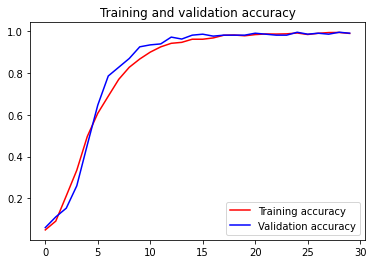

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()



plt.show()

<Figure size 432x288 with 0 Axes>

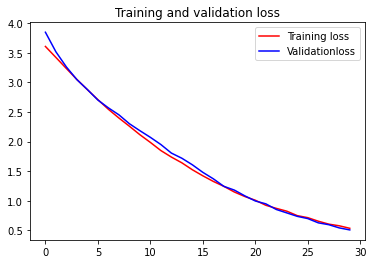

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validationloss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Dropout,BatchNormalization,Conv2D,MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from  skimage.transform import resize
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import pickle


In [ ]:
training_dir="/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/"
content=sorted(os.listdir(training_dir))
print(content)
len(content)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


36

In [ ]:
data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(training_dir, target_size=(200,200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="training")

validation_generator = data_generator.flow_from_directory(training_dir, target_size=(200, 200), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=64, subset="validation")

Found 1944 images belonging to 36 classes.
Found 215 images belonging to 36 classes.


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Models/ISL_inceptionV3.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


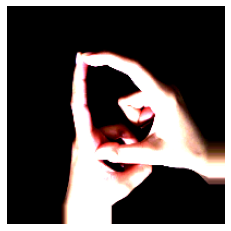

True label: D
Predicted label: D


In [ ]:
import matplotlib.pyplot as plt
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(validation_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES= ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
def prepare(filepath):
    IMG_SIZE=200
    img_array=cv2.imread(filepath)
    img_array = img_array / 255.0
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)


prediction = model.predict(prepare('/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/R/R (16).jpg'))
prediction = np.argmax(prediction,-1)
print(prediction)
print(CATEGORIES[int(prediction[0])])

[9]
9


Found 1620 images belonging to 36 classes.
Found 2159 images belonging to 36 classes.
34/34 [==============================] - 187s 6s/step
[[54  1  0 ...  0  0  0]
 [ 3  0  0 ...  0  0  4]
 [21  0 23 ...  0  0  1]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  1 39  0]
 [ 0  0  0 ...  0  0 42]]
              precision    recall  f1-score   support

           0       0.33      0.90      0.48        60
           1       0.00      0.00      0.00        60
           2       0.62      0.38      0.47        60
           3       0.36      0.20      0.26        60
           4       1.00      0.02      0.03        60
           5       0.00      0.00      0.00        60
           6       0.24      0.20      0.22        60
           7       0.53      0.43      0.48        60
           8       0.45      0.55      0.50        60
           9       0.20      0.40      0.27        60
           A       0.61      0.55      0.58        60
           B       0.48      0.93      0.64        60
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


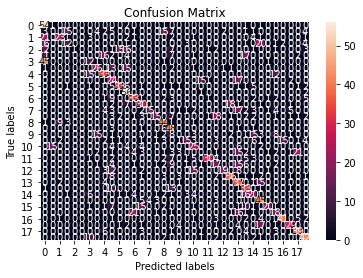

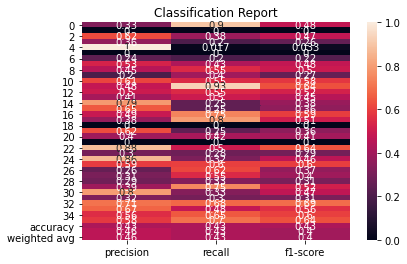

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import math 
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
batch_size=64
target_size=(224,224)
#Calling the saved model for making predictions
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                 validation_split=0.25)

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')
validation_generator = train_datagen.flow_from_directory(
                 '/content/drive/My Drive/Minor project-ISL detection/OUR_ISL dataset/',
                 target_size=target_size, 
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
validation_generator.reset()
model = tf.keras.models.load_model('/content/drive/My Drive/Models/ISL_inceptionV3.h5')

pred=model.predict(validation_generator,
                            verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=validation_generator.filenames
a={"Filename":filenames,"Predictions":predictions}
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#create a function for visualizing model performance 

def PerformanceReports(conf_matrix,class_report,labels):
    ax= plt.subplot()
    sns.heatmap(conf_matrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T,  
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()
    from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
    labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
test_labels = [fn.split('/')[0] for fn in filenames]

cm=confusion_matrix(test_labels,predictions)
print(cm)
cr=classification_report(test_labels, predictions)
class_report=classification_report(test_labels, predictions,
                                   target_names=labels,
                                   output_dict=True)
print(cr)
PerformanceReports(cm,class_report,labels)

In [ ]:
y_pred=predictions
y_true=test_labels
def plot_confusion_matrix(cm,
                          target_names,
                          output_file,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(24, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(output_file)
    plt.show()
  

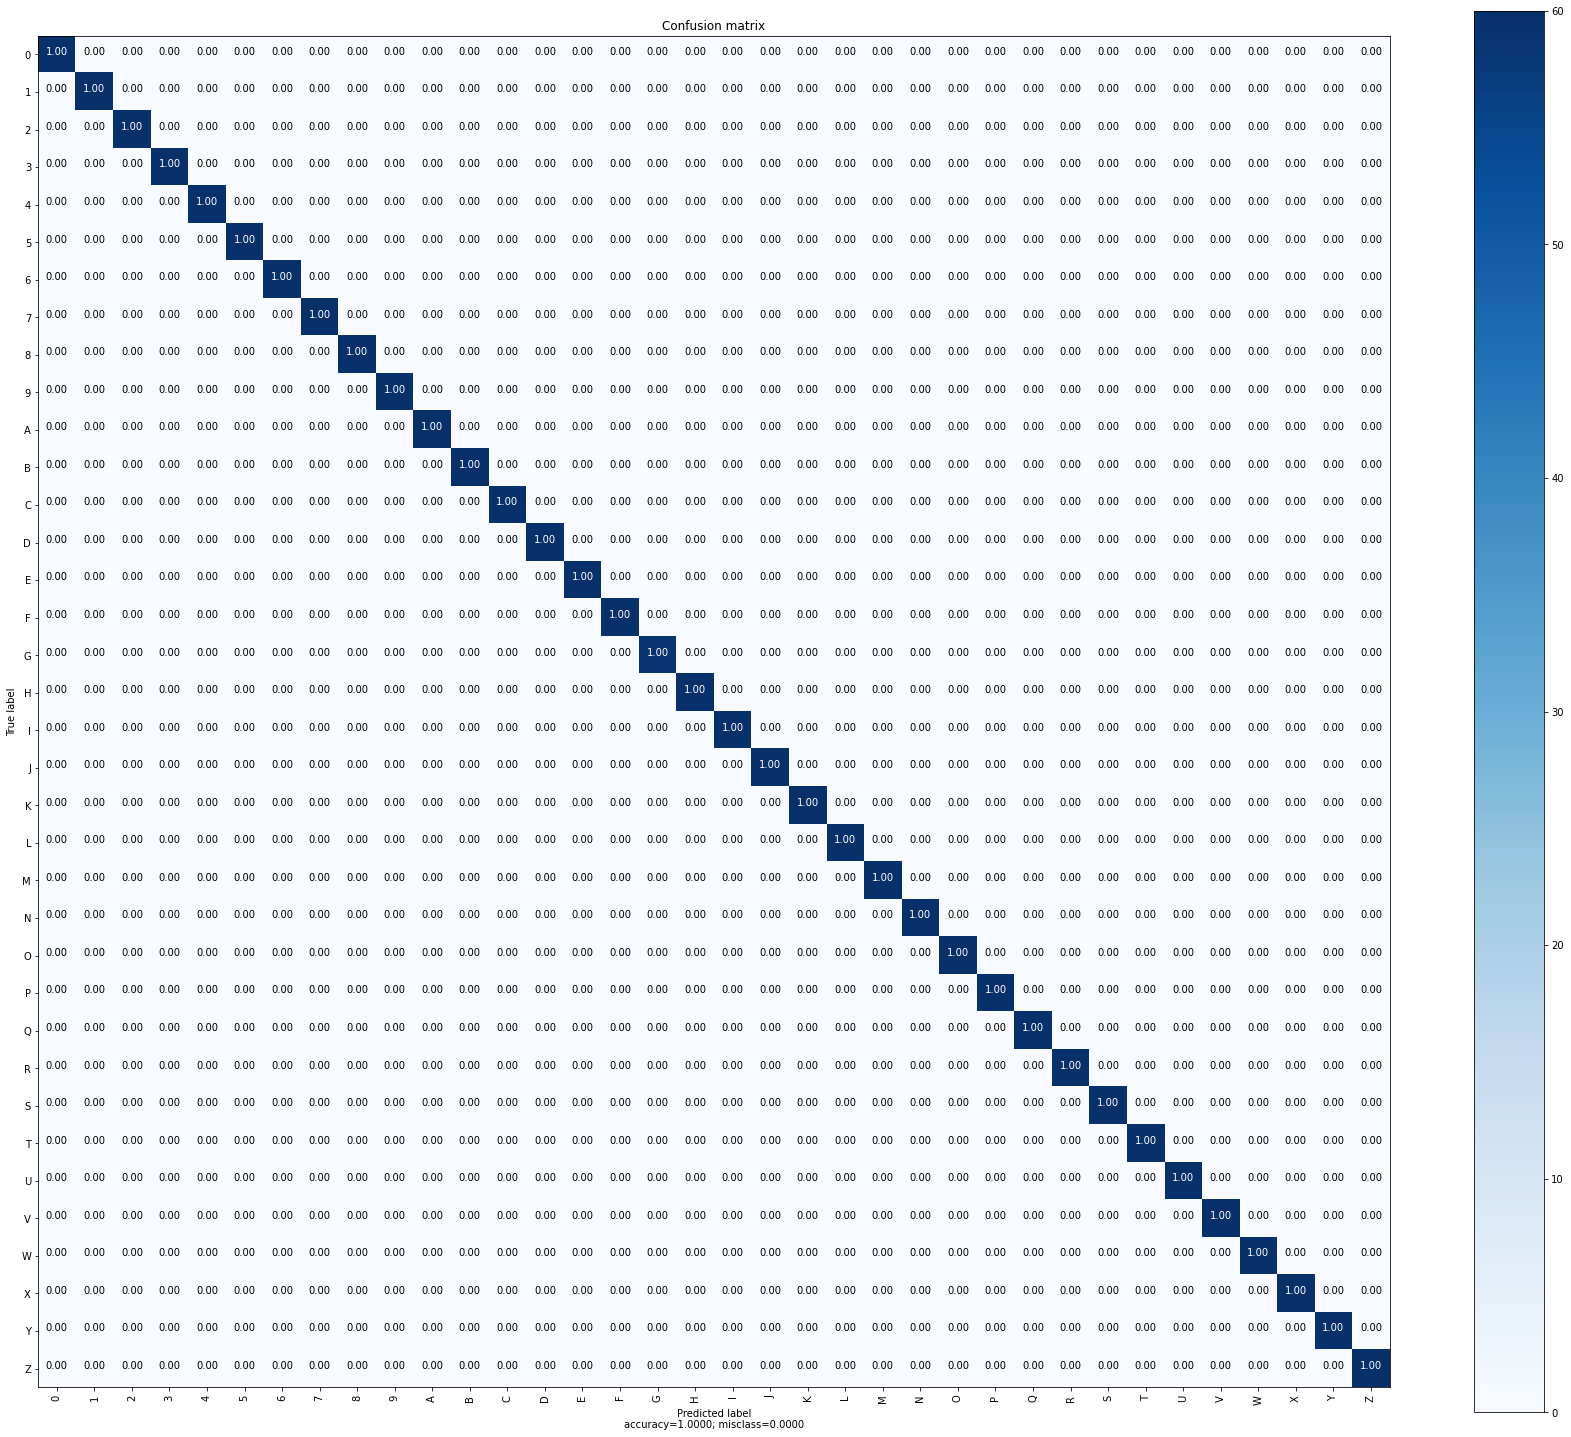

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
output_file='/content/drive/My Drive/'
# Plotting non-normalized confusion matrix
plot_confusion_matrix(cm, class_names, output_file, title='Confusion matrix')